In [1]:
import nltk
import gzip, pickle
import pandas as pd
from nltk import conlltags2tree
pd.set_option('display.max_colwidth', None)

### Load and Understanding the Dataset

The dataset is provided in five folds, each fold having a training, validation and a dict. Load the dataset using pickle and checkout the abservations.

In [2]:
file_name = 'data//ATIS-dataset//atis.fold0.pkl.gz'
f = gzip.open(file_name)
try:
    train_set, valid_set, test_set, dicts = pickle.load(f, encoding='latin1')
except:
    print("usual")
    train_set, valid_set, test_set, dicts = pickle.load(f)
finally:
    f.close()

In [3]:
train_data = pd.DataFrame({"Query":train_set[0], "label":train_set[2]})
valid_data = pd.DataFrame({"Query":valid_set[0], "label":valid_set[2]})
test_data = pd.DataFrame({"Query":test_set[0], "label":test_set[2]})
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   3983 non-null   object
 1   label   3983 non-null   object
dtypes: object(2)
memory usage: 62.4+ KB


In [4]:
train_data

,Query,label
0,"[554, 194, 268, 64, 62, 16, 8, 234, 481, 20, 40, 58, 234, 415, 205]","[126, 126, 126, 48, 126, 36, 35, 126, 126, 33, 126, 126, 126, 78, 123]"
1,"[554, 241, 481, 14, 200, 91, 26, 239]","[126, 126, 126, 126, 126, 2, 83, 83]"
2,"[232, 0, 273, 502, 254, 481, 165, 193, 208, 77, 502, 64]","[126, 126, 126, 126, 126, 126, 42, 126, 126, 48, 126, 78]"
3,"[439, 301, 481, 532, 22, 194, 208, 64, 502, 77]","[126, 126, 126, 2, 83, 126, 126, 48, 126, 78]"
4,"[439, 301, 481, 99, 410, 516, 208, 128, 502, 69]","[126, 126, 126, 21, 66, 117, 126, 48, 126, 78]"
...,...,...
3978,"[439, 301, 190, 105, 194, 359, 544, 471, 502, 452, 286]","[126, 126, 18, 92, 126, 66, 117, 48, 126, 78, 123]"
3979,"[358, 193, 532, 22, 11, 208, 415, 205, 502, 69, 554, 500, 40, 554, 104, 157, 481, 381, 458, 234, 73]","[126, 126, 2, 83, 43, 126, 48, 109, 126, 78, 126, 45, 126, 126, 126, 126, 126, 126, 126, 126, 126]"
3980,"[276, 347, 353, 374, 480, 89, 70, 7, 358, 163, 526, 353, 381, 480, 192, 73, 379, 40, 69]","[126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 48, 126, 78]"
3981,"[241, 481, 37, 193, 10, 208, 77, 502, 351, 13, 339, 193]","[126, 126, 2, 126, 43, 126, 48, 126, 78, 126, 44, 126]"


__Column 1: Query__

The first list is the tokenized words of the queries, encoded by integers such as 554, 194, 268 ... and so on. For e.g. the first three integers 554, 194, 268 are encoded values of the words 'what', 'flights', 'leave' etc. 

#### A dictionary is provided along with the dataset that maps the integers ids to the actual words.

In [5]:
words = pd.Series(list(dicts['words2idx'].keys()), index=dicts['words2idx'].values())
words.tail()

127       daily
140     departs
315    missouri
456    starting
223       hello
dtype: object

In [6]:
### Recreate text query from the dataset
train_data['query_text'] = train_data.Query.apply(lambda q: [words.at[i] for i in q])
train_data['query_text'].head()

0    [what, flights, leave, atlanta, at, about, DIGIT, in, the, afternoon, and, arrive, in, san, francisco]
1                                     [what, is, the, abbreviation, for, canadian, airlines, international]
2                                 [i, 'd, like, to, know, the, earliest, flight, from, boston, to, atlanta]
3                                              [show, me, the, us, air, flights, from, atlanta, to, boston]
4                                      [show, me, the, cheapest, round, trips, from, dallas, to, baltimore]
Name: query_text, dtype: object

In [7]:
valid_data['query_text'] = valid_data.Query.apply(lambda q: [words.at[i] for i in q])
test_data['query_text'] = test_data.Query.apply(lambda q: [words.at[i] for i in q])

__Column 2: Labels__

Labels are similar to POS tags, where instead of using noun, verb, etc, we’ll use IOB (inside-outside-beginning) tags of entities like flight-time, source-city, etc. 

#### A similar dictionary is provided along with the dataset that maps the integers ids to the actual iob labels.

In [8]:
labels = pd.Series(list(dicts['labels2idx'].keys()), index=dicts['labels2idx'].values())
labels.tail()

0                   B-aircraft_code
116    I-return_date.today_relative
55                     B-month_name
49             B-fromloc.state_code
96           I-depart_time.end_time
dtype: object

In [9]:
# Check IOB labels from the label dataset
train_data['iob_labels'] = train_data.label.apply(lambda l: [labels.at[i] for i in l])
train_data['iob_labels'].head()

0    [O, O, O, B-fromloc.city_name, O, B-depart_time.time_relative, B-depart_time.time, O, O, B-depart_time.period_of_day, O, O, O, B-toloc.city_name, I-toloc.city_name]
1                                                                                                         [O, O, O, O, O, B-airline_name, I-airline_name, I-airline_name]
2                                                                                       [O, O, O, O, O, O, B-flight_mod, O, O, B-fromloc.city_name, O, B-toloc.city_name]
3                                                                              [O, O, O, B-airline_name, I-airline_name, O, O, B-fromloc.city_name, O, B-toloc.city_name]
4                                                                    [O, O, O, B-cost_relative, B-round_trip, I-round_trip, O, B-fromloc.city_name, O, B-toloc.city_name]
Name: iob_labels, dtype: object

In [10]:
valid_data['iob_labels'] = valid_data.label.apply(lambda l: [labels.at[i] for i in l])
test_data['iob_labels'] = test_data.label.apply(lambda l: [labels.at[i] for i in l])

### IOB Labels

IOB (or BIO) method tags each token in the sentence with one of the three labels: 

I - inside (the entity) 
O- outside (the entity)  
B - beginning (of entity). 

IOB labeling is especially helpful if the entities contain multiple words. We would want our system to read words like ‘Air India’, ‘New Delhi’, etc, as single entities.

Any entity with more than 2 words such as ‘Dallas Fort Worth’, ‘Smoke House Deli’, the first word of the entity would be labeled as B-entity and other words in it would be labeled as I-entity, rest would be labeled as O.

In [11]:
query_label = lambda idx: list(zip(train_data.query_text.at[idx], train_data.iob_labels.at[idx]))
query_label(3900)

[('please', 'O'),
 ('show', 'O'),
 ('me', 'O'),
 ('the', 'O'),
 ('return', 'O'),
 ('flight', 'O'),
 ('number', 'O'),
 ('from', 'O'),
 ('toronto', 'B-fromloc.city_name'),
 ('to', 'O'),
 ('st.', 'B-toloc.city_name'),
 ('petersburg', 'I-toloc.city_name')]

In [12]:
# Entities with more than one words in it will be tagged with prefix `i`
query_label(3443)

[('is', 'O'),
 ('there', 'O'),
 ('a', 'O'),
 ('flight', 'O'),
 ('between', 'O'),
 ('oakland', 'B-fromloc.city_name'),
 ('and', 'O'),
 ('boston', 'B-toloc.city_name'),
 ('with', 'O'),
 ('a', 'O'),
 ('stopover', 'O'),
 ('in', 'O'),
 ('dallas', 'B-stoploc.city_name'),
 ('fort', 'I-stoploc.city_name'),
 ('worth', 'I-stoploc.city_name'),
 ('on', 'O'),
 ('twa', 'B-airline_code')]

## Information Extacrion

Retrieving structured information like enititis and/or relationship between entities from unstructured text data.

### IE Pipeline

__Sentence Tokenization__ sequence segmentation of text.

__Word Tokenization__ breaks down sentences into tokens

__PoS tagging__ assigning PoS tags to the tokens. The POS tags can be helpful in defining what words could form an entity.


In __entity recognition__, every token is tagged with an IOB label and then nearby tokens are combined together basis their labels.

__Relation Recognition__ is the task of identifying relationships between the named entities. Using entity recognition, we can identify places (pl), organisations (o), persons (p). Relation recognition will find the relation between (pl,o), such that o is located in pl. Or between (o,p), such that p is working in o, etc.

### Preprocessing

Generally, initial tasks in preprocessig involves data cleaning, sentence and word tokenisation. The ATIS dataset that we have is already in tokenized form, that means we are ready to proceed with the next step of preprocessing. 

In [13]:
train_data['pos'] = train_data['query_text'].apply(nltk.pos_tag)
train_data['pos'].head()

0    [(what, WP), (flights, NNS), (leave, VBP), (atlanta, VBN), (at, IN), (about, RB), (DIGIT, NNP), (in, IN), (the, DT), (afternoon, NN), (and, CC), (arrive, NN), (in, IN), (san, JJ), (francisco, NN)]
1                                                                                 [(what, WP), (is, VBZ), (the, DT), (abbreviation, NN), (for, IN), (canadian, JJ), (airlines, NNS), (international, JJ)]
2                                                      [(i, JJ), ('d, MD), (like, VB), (to, TO), (know, VB), (the, DT), (earliest, JJS), (flight, NN), (from, IN), (boston, NN), (to, TO), (atlanta, VB)]
3                                                                             [(show, VB), (me, PRP), (the, DT), (us, PRP), (air, NN), (flights, NNS), (from, IN), (atlanta, NN), (to, TO), (boston, VB)]
4                                                                     [(show, VB), (me, PRP), (the, DT), (cheapest, JJS), (round, NN), (trips, NNS), (from, IN), (dallas, NN), (to, TO), (baltim

In [14]:
test_data['pos'] = test_data['query_text'].apply(nltk.pos_tag)
valid_data['pos'] = valid_data['query_text'].apply(nltk.pos_tag)

Now that we have converted the queries in the form (word, pos, label), we can convert them into a tree format and observe the actual entities more clearly (rather than IOB labels).

In [15]:
word_pos_iob = lambda x: [tuple([t for t in p]+[l]) for p, l in zip(list(x.pos),x.iob_labels)]

In [16]:
train_labels = train_data.apply(word_pos_iob, axis=1)
test_labels = test_data.apply(word_pos_iob, axis=1)
valid_labels = valid_data.apply(word_pos_iob, axis=1)

In [17]:
# printing some sample queries in the form (word, pos, label)
# train_labels = create_word_pos_label(train_data.pos, train_data.label)
train_labels[4:6]

4    [(show, VB, O), (me, PRP, O), (the, DT, O), (cheapest, JJS, B-cost_relative), (round, NN, B-round_trip), (trips, NNS, I-round_trip), (from, IN, O), (dallas, NN, B-fromloc.city_name), (to, TO, O), (baltimore, VB, B-toloc.city_name)]
5                                 [(i, JJ, O), ('d, MD, O), (like, VB, O), (to, TO, O), (see, VB, O), (all, DT, O), (flights, NNS, O), (from, IN, O), (denver, NN, B-fromloc.city_name), (to, TO, O), (philadelphia, VB, B-toloc.city_name)]
dtype: object

In [18]:
# converting training, validation and test datasets to tree format
train_trees = [conlltags2tree(sent) for sent in train_labels]
valid_trees = [conlltags2tree(sent) for sent in valid_labels]
test_trees = [conlltags2tree(sent) for sent in test_labels]

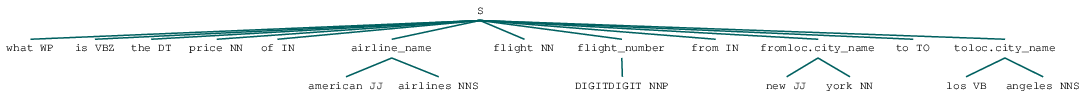

In [19]:
train_trees[8]

In [20]:
pd.DataFrame(train_labels[8], columns=['Word', 'pos', 'BOI']) #.drop('pos', axis=1).drop(8).reset_index().drop('index', axis=1)

,Word,pos,BOI
0,what,WP,O
1,is,VBZ,O
2,the,DT,O
3,price,NN,O
4,of,IN,O
5,american,JJ,B-airline_name
6,airlines,NNS,I-airline_name
7,flight,NN,O
8,DIGITDIGIT,NNP,B-flight_number
9,from,IN,O


### Feature Extraction

Like anyother machine learning classification models, we can have features for sequence labelling task. Features could be the morphology of the word  (upper/lowercase) , POS tags of the words in the neighbourhood, whether the word is present in the lookup dictionary of some most common entities like geograpyical locations etc.

### Gazetteer

A gazetteer is a geographical directory which stores data regarding the names of geographical entities (cities, states, countries) and some other features related to the geographies. An example gazetteer file for the US is given below.

Data download URL: https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv

In [21]:
# reading a file containing list of US cities, states and counties
us_cities = pd.read_csv("data/us_cities_states_counties.csv", sep="|")
us_cities.head()

,City,State short,State full,County,City alias
0,Holtsville,NY,New York,SUFFOLK,Internal Revenue Service
1,Holtsville,NY,New York,SUFFOLK,Holtsville
2,Adjuntas,PR,Puerto Rico,ADJUNTAS,URB San Joaquin
3,Adjuntas,PR,Puerto Rico,ADJUNTAS,Jard De Adjuntas
4,Adjuntas,PR,Puerto Rico,ADJUNTAS,Colinas Del Gigante


In [22]:
# storing cities, states and counties as sets
cities = set(us_cities['City'].str.lower())
states = set(us_cities['State full'].str.lower())
counties = set(us_cities['County'].str.lower())

In [23]:
# define a function to look up a given word in cities, states, county
def gazetteer_lookup(word):
    return (word in cities, word in states, word in counties)

In [24]:
gazetteer_lookup('huston')

(True, False, False)

Lets create a function to extract some of the useful predictors of IOB labels, such as, the word itself,  pos tag, previous pos, word_is_city, word_is_state, and word_is_country.

In [25]:
def npchunk_features(sentence, i, history=[]):
    word, pos = sentence[i]
    
    #the first word has both prv and next tag undefined
    if i==0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
        
    gazetteer = gazetteer_lookup(word)
    
    return {"pos":pos, "prevpos": prevpos, "word":word,
           "word_is_city": gazetteer[0],
           "word_is_state": gazetteer[1],
           "word_is_country": gazetteer[2]}

In [26]:
train_data.pos.at[3]

[('show', 'VB'),
 ('me', 'PRP'),
 ('the', 'DT'),
 ('us', 'PRP'),
 ('air', 'NN'),
 ('flights', 'NNS'),
 ('from', 'IN'),
 ('atlanta', 'NN'),
 ('to', 'TO'),
 ('boston', 'VB')]

In [27]:
for i in range(len(train_data.pos.at[3])):
    print(npchunk_features(train_data.pos.at[3], i))

{'pos': 'VB', 'prevpos': '<START>', 'word': 'show', 'word_is_city': False, 'word_is_state': False, 'word_is_country': False}
{'pos': 'PRP', 'prevpos': 'VB', 'word': 'me', 'word_is_city': False, 'word_is_state': False, 'word_is_country': False}
{'pos': 'DT', 'prevpos': 'PRP', 'word': 'the', 'word_is_city': False, 'word_is_state': False, 'word_is_country': False}
{'pos': 'PRP', 'prevpos': 'DT', 'word': 'us', 'word_is_city': False, 'word_is_state': False, 'word_is_country': False}
{'pos': 'NN', 'prevpos': 'PRP', 'word': 'air', 'word_is_city': False, 'word_is_state': False, 'word_is_country': False}
{'pos': 'NNS', 'prevpos': 'NN', 'word': 'flights', 'word_is_city': False, 'word_is_state': False, 'word_is_country': False}
{'pos': 'IN', 'prevpos': 'NNS', 'word': 'from', 'word_is_city': False, 'word_is_state': False, 'word_is_country': False}
{'pos': 'NN', 'prevpos': 'IN', 'word': 'atlanta', 'word_is_city': True, 'word_is_state': False, 'word_is_country': False}
{'pos': 'TO', 'prevpos': 'NN',

## Model - DecisionTreeClassifier

Now, we define two classes ConsecutiveNPChunkTagger and ConsecutiveNPChunker.

The __init__ method of the ConsecutiveNPChunkTagger class creates the train_set which is a list of labelled training sentences. Each sentence is a list of tuples (featureset, tag) - each tuple is the featureset (dict) of a word and its label.

The list history contains the list of previously predicted IOB tags, i.e. tags to the left of the target word. We can only use IOB tags to the left of the target word since that's all the tags we have at the time of prediction.

The __init__ method takes in an IOB tagged list of train_sents and loops through them. It first untags the IOB tags to generate (word, pos_tag) tuples stored in untagged_sent. These tuples are used to compute the word features.

Then for each (word, IOB_tag) in tagged_sent, it computes the word features and appends the feature dict and the tag to train_sents. It further appends the IOB tag to history.

The tag() method simply takes in a sentence as a list of words and predicts the IOB label of each word in the sentence.

The ConsecutiveNPChunker class does all the the uninteresting work of converting between tree-list-tree formats (since NLTK's builtin classifiers need the list format). It takes in a list of sentences as trees, converts each sentence to the list form, and then initialises its tagger using methods already defined in the ConsecutiveNPChunkTagger class. The parse method tags the sentence and returns it in the tree format since it is easier to print and read.

In [28]:
#Using NLTK's Naive Bayes Classifier
class ConsecutiveNPChunkTagger(nltk.TaggerI): 

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            # compute features for each word
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history) 
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.NaiveBayesClassifier.train(train_set)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI): 
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [29]:
# train and evaluate the decision tree chunker
tree_chunker = ConsecutiveNPChunker(train_trees)
print(tree_chunker.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  91.7%%
    Precision:     75.3%%
    Recall:        81.8%%
    F-Measure:     78.4%%


In [30]:
# Decision Tree Classifier
class ConsecutiveNPChunkTagger(nltk.TaggerI): 

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            # compute features for each word
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history) 
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.DecisionTreeClassifier.train(train_set)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI): 
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [31]:
# train and evaluate the decision tree chunker
tree_chunker = ConsecutiveNPChunker(train_trees)
print(tree_chunker.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  94.0%%
    Precision:     82.1%%
    Recall:        84.8%%
    F-Measure:     83.4%%


In [32]:
scores = pd.DataFrame({'Model': ['Naive Bayes', 'Decision Tree', 'Naive Bayes', 'Decision Tree', 'Naive Bayes', 'Decision Tree', 'Naive Bayes', 'Decision Tree'], 
              'Score':['Accuracy', 'Accuracy' , 'Precision', 'Precision', 'Recall', 'Recall', 'F-Score', 'F-Score'], 
              'Value':[91.7, 94, 75.3, 82.1, 81.8, 84.8, 78.4, 83.4]})

scores.sort_values(by='Model')

,Model,Score,Value
1,Decision Tree,Accuracy,94.0
3,Decision Tree,Precision,82.1
5,Decision Tree,Recall,84.8
7,Decision Tree,F-Score,83.4
0,Naive Bayes,Accuracy,91.7
2,Naive Bayes,Precision,75.3
4,Naive Bayes,Recall,81.8
6,Naive Bayes,F-Score,78.4


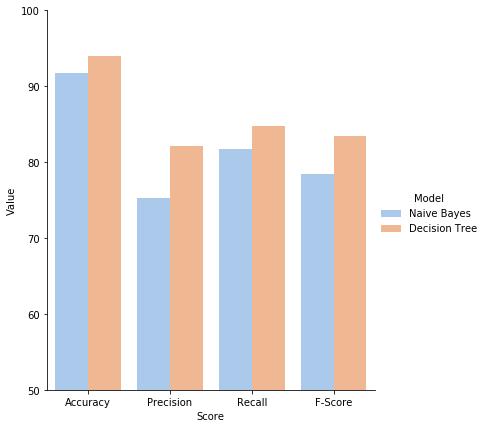

In [33]:
import seaborn as sns

a_plot = sns.catplot(x="Score", y="Value", hue="Model", data=scores, kind="bar", height=6, aspect=.9, palette='pastel')

a_plot.set(ylim=(50, 100))

We can of course also tune the decision tree hyperparameters (maxdepth, num_leaves, min_sample_split etc.) to optimize the model as per the need.